In [37]:
#!pip install networkx --user
import numpy as np
import networkx as nx
print("Networkx version: {}".format(nx.__version__))
from time import time
import matplotlib.pyplot as plt
import random
import seaborn as sns
sns.set()

print("numpy version: {}".format(np.__version__))
print("Networkx version: {}".format(nx.__version__))

from scipy.stats import norm
import numexpr
numexpr.print_versions()
%matplotlib inline

Networkx version: 2.4
numpy version: 1.18.1
Networkx version: 2.4
*Warning*: NumPy version is lower than recommended: 1.18.1 < 1.7.0
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Numexpr version:   2.6.8
NumPy version:     1.18.1
Python version:    3.7.6 (default, Jan  8 2020, 19:59:22) 
[GCC 7.3.0]
Platform:          linux-x86_64-#1 SMP Mon Sep 16 14:19:51 EDT 2019
CPU vendor:        
CPU model:         
CPU clock speed:    MHz
VML available?     True
VML/MKL version:   Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
Number of threads used by default: 8 (out of 64 detected cores)
Maximum number of threads: 64
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=


In [32]:
import tensorflow as tf
print(tf.__version__)

import os
print(os.environ['HOME'])
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

if tf.test.gpu_device_name() == '/device:GPU:0':
  print("Using a GPU")
else:
  print("Using a CPU")

import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions
tfb = tfp.bijectors

from tensorflow_probability import edward2 as ed
tfd = tfp.distributions

2.0.0
/u/yan30
Using a GPU


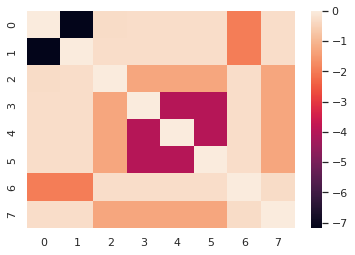

In [38]:
Gorig = nx.read_edgelist("data/resnik.txt", delimiter='\t' , nodetype=str,  data=(('weight',float),))
for u,v,d in Gorig.edges(data=True):
    Gorig[u][v]['weight']=-Gorig[u][v]['weight'] + np.random.normal(0,0.001)
H = Gorig.subgraph(['ACD', 'ABL1', 'ACTL6A', 'ACTR5', 'ACTR8', 'ALKBH1', 'ALKBH2', 'ALKBH3'])
mapping = {'ACD':6, 'ABL1':3, 'ACTL6A':7, 'ACTR5':5, 'ACTR8':0, 'ALKBH1':1, 'ALKBH2':2, 'ALKBH3':4}
G0 = nx.relabel_nodes(H, mapping)
A = nx.adjacency_matrix(G0).todense()
ax = sns.heatmap(A)

In [41]:
from networkx import relabel

Gnew = relabel.convert_node_labels_to_integers(Gorig, label_attribute = "term") #initilaization
terms = nx.get_node_attributes(Gnew, 'term')
terms

{0: 'ACD',
 1: 'ABL1',
 2: 'ACTL6A',
 3: 'ACTR5',
 4: 'ACTR8',
 5: 'ALKBH1',
 6: 'ALKBH2',
 7: 'ALKBH3',
 8: 'AMN1',
 9: 'ANKRD28',
 10: 'ANKRD44',
 11: 'ANKRD52',
 12: 'APEX1',
 13: 'APEX2',
 14: 'APITD1',
 15: 'APLF',
 16: 'APTX',
 17: 'ARID1A',
 18: 'ARID1B',
 19: 'ARID2',
 20: 'ASF1A',
 21: 'ASF1B',
 22: 'ATF2',
 23: 'ATM',
 24: 'ATR',
 25: 'ATRIP',
 26: 'ATRX',
 27: 'ATXN3',
 28: 'BAP1',
 29: 'BARD1',
 30: 'BAZ1A',
 31: 'BAZ1B',
 32: 'BCAS2',
 33: 'BLM',
 34: 'BRCA1',
 35: 'BRCA2',
 36: 'BRCC3',
 37: 'BRD7',
 38: 'BRE',
 39: 'BRIP1',
 40: 'BTG2',
 41: 'CCDC98',
 42: 'CCNA1',
 43: 'CCNA2',
 44: 'CCNB1',
 45: 'CCNB2',
 46: 'CCNB3',
 47: 'CCND1',
 48: 'CCND2',
 49: 'CCND3',
 50: 'CCNE1',
 51: 'CCNH',
 52: 'CCNO',
 53: 'CDC25A',
 54: 'CDC25B',
 55: 'CDC5L',
 56: 'CDK2',
 57: 'CDK4',
 58: 'CDK7',
 59: 'CDKN1A',
 60: 'CDKN2A',
 61: 'CDKN2D',
 62: 'CETN2',
 63: 'CHAF1A',
 64: 'CHEK1',
 65: 'CHEK2',
 66: 'CHRAC1',
 67: 'CIB1',
 68: 'CLK2',
 69: 'CLSPN',
 70: 'CNOT7',
 71: 'COPS2',
 72: 'C

In [15]:
#Define the joint_log_prob function, and our unnormalized posterior.
def SBM_prob(G, k, labels, directed=False, selfloops=False):
  # the SBM log-likelihood generative steps
    n = len(G)
    z = labels
    eta = ed.Normal(loc=10, scale=1, name="eta", sample_shape=[k,k]) #beta prior for simple edges
    # parameters to sample the adjacency matrix
    # p[i, j] = eta[z[i], z[j]] is the parameter corresponding to A[i, j]
    # very inefficient parameterization
    tile_a = tf.tile(tf.expand_dims(z, 1), [1, tf.shape(z)[0]])  
    tile_a = tf.expand_dims(tile_a, 2) 
    tile_b = tf.tile(tf.expand_dims(z, 0), [tf.shape(z)[0], 1]) 
    tile_b = tf.expand_dims(tile_b, 2)
    p = tf.gather_nd(eta, tf.concat([tile_a, tile_b], axis=2))
    #if not selfloops:
    #    TT.set_subtensor(p[np.diag_indices(n)], 0.)
    #if not directed:
    #    p = eta[(z.reshape((n, 1)), z.reshape((1, n)))][triu_indices] #replace with equation 5.5 for analytical posterior, including DC?
    #if weighted:
    #    A = ed.Poisson(name = 'A', mu=p, shape=A_obs[0].shape, observed=A_obs) #collect edge/non-edge statistics for the analytical posterior
    #else:
    A = ed.Normal(name = 'A', loc=p, scale=1)
    return A

In [16]:
log_joint = ed.make_log_joint_fn(SBM_prob)
# Function to compute the log posterior probability
n = len(Gorig)
A_obs = tf.convert_to_tensor(nx.to_numpy_array(Gorig), dtype=tf.float32)

#def setParameters(k, label):
k = 3
label = np.random.randint(low = 0, high = 3, size = n) 

def target_log_prob_fn(eta):
  return log_joint(
      G = Gorig,
      k = label.max()+1,
      labels = label,
      eta = eta,
      A=A_obs)

# set initial state (drawn from prior)
peta = tf.random.uniform([k,k], minval=0, maxval=1, dtype=tf.float32)
x = target_log_prob_fn(peta)+305621 #test the target_log_prob_fn with initial state
print(x)
np.exp(-300)

/home/yan30/.tfProb/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: tfp.edward2 module is deprecated and will be removed on 2019-12-01. Use https://github.com/google/edward2 library instead.
  """Entry point for launching an IPython kernel.


tf.Tensor(-144663.4, shape=(), dtype=float32)


5.148200222412013e-131

In [17]:
Nsamples = 100  # final number of samples
Nburn = 100     # number of tuning samples

# set up Hamiltonian MC
def sampleMedian(peta, target_log_prob_fn):
    hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=target_log_prob_fn,
        step_size=0.01,
        num_leapfrog_steps=5)

    states, kernel_results = tfp.mcmc.sample_chain(
        num_results=Nsamples,
        num_burnin_steps=Nburn,
        current_state=[peta],
        trace_fn=(lambda current_state, kernel_results: kernel_results),
        parallel_iterations=100,
        kernel=hmc_kernel)
    return np.median(kernel_results.proposed_results.target_log_prob.numpy()) ##median for posterior estimates
#kernel_results.is_accepted.numpy().mean()

In [18]:
# Merge quasi-cliques with more than 3 overlapping nodes
def merge_cliques(Clist):
    c1 = Clist[0]
    for i in range(1, len(Clist)):
        c2 = Clist[i]
        if (len(c1.intersection(c2))>1): # define quasi-cliques with number of overlapping nodes
            c3 = c1.union(c2)
            Clist.insert(0,c3)
            Clist.remove(c1)
            Clist.remove(c2)
            return merge_cliques(Clist)
    return Clist

In [19]:
import networkx.algorithms.clique as clique
import itertools as it

def getCandidates(G, labels):
    edgesTop=sorted(G.edges(data=True), key=lambda t: t[2].get('weight', 1))
    #percent = int(len(edgesTop)/5000) # adjust for layer size
    eList = [(x[0],x[1]) for x in edgesTop[:10]]
    sub = G.edge_subgraph(eList)
    graphs = [sub.subgraph(c) for c in nx.connected_components(sub)]
    print(len(graphs))
    max_clique_sets = [clique.find_cliques(s) for s in graphs]
    cliques = []
    for clist in max_clique_sets:
        tmp = []
        for c in clist:
            if (len(c)>=2): #(len(c)<=3) control size of cliques
                cohesion = 0
                for idx, x in enumerate(c):
                    for idy, y in enumerate(c):
                        if (idy>idx):
                            cohesion = cohesion + G[x][y]['weight']
                tup = (set(c),cohesion/(len(c)-1)/(len(c)-1)) #higher order cliques prioritized
                tmp.append(tup)
        tmp = sorted(tmp, key=lambda t: t[1]) #sort cliques
        cliques += tmp[:3] #keep only top 3 cliques for each component
    
    CliList = sorted(cliques, key=lambda t: t[1])
    print(CliList)
    cliquesFiltered0 = [x[0] for x in CliList]
    cliquesFiltered = merge_cliques(cliquesFiltered0)

    CliXO = {}    
    nodeSet = sorted(set().union(*cliquesFiltered))
    for x in nodeSet:
        CliXO[x] = []
        for idx, y in enumerate(cliquesFiltered): 
            if (x in y) and len(CliXO[x])<2: #only top 3 appearance are considered in Bayesian assignments
                CliXO[x].append(idx)
    combinations = it.product(*(CliXO[Name] for Name in nodeSet))
    Llist = []
    for update in combinations:
        labelsNew = labels.copy()    
        for idx, x in enumerate(update):
            labelsNew[nodeSet[idx]] = len(labels)+x
        b,c =np.unique(labelsNew, return_inverse=True)
        Llist.append(c)
    return Llist

In [20]:
def buildLayer(Gnew, knew, Llist):
    Mlist = []
    A_obs = tf.convert_to_tensor(nx.to_numpy_array(Gnew), dtype=tf.float32)
    for iteration in range (0,len(Llist)):
        label = Llist[iteration]
        def target_log_prob_fn(eta):
          return log_joint(
              G = Gnew,
              k = knew,
              labels = label,
              eta = eta,
              A=A_obs)

        peta = tf.random.uniform([knew,knew], minval=0, maxval=1, dtype=tf.float32)
        tup = (iteration,sampleMedian(peta,target_log_prob_fn)) #tuple for index and posterior
        Mlist.append(tup)
    #Mlist = np.exp(Mlist - max(Mlist))
    #norm = [float(i)/sum(Mlist) for i in Mlist] 
    return sorted(Mlist, key=lambda t: t[1], reverse = True) #higher order cliques prioritized

In [21]:
def updateDAG(G, NodeMerge, terms):
    size = len(NodeMerge);
    nodeSet = sorted(set().union(*NodeMerge))
    A = nx.adjacency_matrix(G).todense()
    while len(NodeMerge)>0:
        nodes = NodeMerge.pop()
        newNodeV = np.sum(A[nodes,:],axis=0)/len(nodes)
        B = np.vstack([A, newNodeV])
        newNodeC = np.sum(B[:,nodes],axis=1)/len(nodes)
        A = np.column_stack([B, newNodeC])
        
    #print(nodeSet)
    A = np.delete(A, nodeSet, axis = 0)
    #print(A.shape)
    A = np.delete(A, nodeSet, axis = 1)
    dt=[('weight',float)]
    A = np.matrix(A,dtype=dt)
    np.fill_diagonal(A, 0)
    Gnew = nx.from_numpy_matrix(A)
    Gnew = relabel.convert_node_labels_to_integers(Gnew) 
    
    for node in nodeSet:
        if node in terms:
            del terms[node]
    return Gnew, {i:v for i,(k,v) in enumerate(terms.items(),0)}

In [31]:
from collections import Counter
from networkx import relabel

#def f():
Gnew = relabel.convert_node_labels_to_integers(Gorig, label_attribute = "term") #initilaization
terms = nx.get_node_attributes(Gnew, 'term') # initilaizatial dictionary for ddot ontology output
hierarchy = [] # for ddot ontology output
subsystem = 0 # for ddot ontology output

while True:
    k = len(Gnew)
    label = np.arange(k)
    print(k)
    Llist = getCandidates(Gnew,label)
    ModelPosterior = buildLayer(Gnew, k-1, Llist)
    print(ModelPosterior)
    newInternal = [x for x in ModelPosterior[:20]] # keep top 10 Bayesian assignemtns
    #newInternal = np.where(np.asarray(ModelPosterior) > thresh)[0] #keep Bayesian candidates above threshold
    NodeMerge = [] #nodes to be merged, nested lists of motifs
    for i in range (0,len(newInternal)): #recreate the filtered merges
        newLabel = Llist[newInternal[i][0]]
        #print(newLabel)        
        dup = [item for item, count in Counter(newLabel).items() if count > 1]
        for dupL in dup: 
            nodes = [idx for idx,label in enumerate(newLabel) if label==dupL]
            if nodes not in NodeMerge:
                NodeMerge.append(nodes)
                for node in nodes: #update ddot ontology 
                    hierarchy.append((terms[node],"subsystem"+str(subsystem),newInternal[i][1])) #update ddot ontology
                terms[len(terms)] = "subsystem"+str(subsystem)
                subsystem += 1
    print(NodeMerge)
    Gnew, terms = updateDAG(Gnew, NodeMerge, terms) #update the graph with node mergers/splits
    #print(terms)
    #print(hierarchy)
    if Gnew.number_of_edges() <=1:
        break    

437
10
[({12, 13}, -7.7732490274743045), ({385, 170}, -7.772068442980078), ({380, 382}, -7.771969351417206), ({401, 402}, -7.77192689365555), ({421, 54}, -7.7718970658663125), ({80, 79}, -7.7714845056605695), ({51, 236}, -7.770857987688253), ({177, 178}, -7.7707015512821815), ({187, 285}, -7.188419526444079), ({179, 175}, -7.1880737534156145)]


KeyboardInterrupt: 

In [265]:
import cProfile 

def f():
    Gnew = relabel.convert_node_labels_to_integers(Gorig, label_attribute = "term") #initilaization
    terms = nx.get_node_attributes(Gnew, 'term') # initilaizatial dictionary for ddot ontology output
    hierarchy = [] # for ddot ontology output
    subsystem = 0 # for ddot ontology output

    while True:
        k = len(Gnew)
        label = np.arange(k)
        print(k)
        Llist = getCandidates(Gnew,label)
        ModelPosterior = buildLayer(Gnew, k-1, Llist)
        print(ModelPosterior)
        newInternal = [x for x in ModelPosterior[:3]] # only consider top 3 Bayesian assignemtns
        #newInternal = np.where(np.asarray(ModelPosterior) > thresh)[0] #keep Bayesian candidates above threshold
        NodeMerge = [] #nodes to be merged, nested lists of motifs
        for i in range (0,len(newInternal)): #recreate the filtered merges
            newLabel = Llist[i]
            #print(newLabel)        
            dup = [item for item, count in Counter(newLabel).items() if count > 1]
            for dupL in dup: 
                nodes = [idx for idx,label in enumerate(newLabel) if label==dupL]
                if nodes not in NodeMerge:
                    NodeMerge.append(nodes)
                    for node in nodes: #update ddot ontology 
                        hierarchy.append((terms[node],"subsystem"+str(subsystem))) #update ddot ontology
                    terms[len(terms)] = "subsystem"+str(subsystem)
                    subsystem += 1
        print(NodeMerge)
        Gnew, terms = updateDAG(Gnew, NodeMerge, terms) #update the graph with node mergers/splits
        #print(terms)
        print(hierarchy)
        if Gnew.number_of_edges() <=1:
            break    
        
cProfile.run('f()') 

437
9
[({322, 326}, -0.00447709186514744), ({331, 92}, -0.004040079422299645), ({165, 54}, -0.0037664295782413545), ({226, 118}, -0.003684335487915642), ({185, 287}, -0.003639636518143077), ({99, 22}, -0.0036259828549470388), ({160, 417}, -0.0035549431888048325), ({112, 433}, -0.0035530411129729286), ({184, 353}, -0.0034993158660048553), ({24, 331}, -0.003461306053937489)]
[-6678344.0, -6682425.0]
[[22, 99], [54, 165], [92, 331], [112, 433], [118, 226], [160, 417], [184, 353], [185, 287], [322, 326], [24, 331]]
[('ATF2', 'subsystem0'), ('DNTT', 'subsystem0'), ('CDC25B', 'subsystem1'), ('MEN1', 'subsystem1'), ('DDB2', 'subsystem2'), ('SIRT1', 'subsystem2'), ('EYA3', 'subsystem3'), ('XRCC6BP1', 'subsystem3'), ('FANCB', 'subsystem4'), ('PIAS2', 'subsystem4'), ('MBD4', 'subsystem5'), ('UVRAG', 'subsystem5'), ('MYBBP1A', 'subsystem6'), ('SMG6', 'subsystem6'), ('NABP1', 'subsystem7'), ('RAD51B', 'subsystem7'), ('RRM2B', 'subsystem8'), ('SETMAR', 'subsystem8'), ('ATR', 'subsystem9'), ('SIRT1'

In [17]:
import pickle

with open('hierarchyQ2.save', 'wb') as fp:
    pickle.dump(hierarchy, fp)

In [15]:
with open ('hierarchyQ3.save', 'rb') as fp:
    itemlist = pickle.load(fp)

hierarchy  = [x for x in itemlist if "subsystem" in str(x[0])]
mapping = [x for x in itemlist if "subsystem" not in str(x[0])]
len(hierarchy)

1113

In [5]:
import pickle

with open ('hierarchyQ3.save', 'rb') as fp:
    itemlist = pickle.load(fp)

hierarchy  = [x for x in itemlist]
hierarchy

[('ALKBH2', 'subsystem0', -7607291.5),
 ('ALKBH3', 'subsystem0', -7607291.5),
 ('APEX1', 'subsystem1', -7607291.5),
 ('APEX2', 'subsystem1', -7607291.5),
 ('CCNH', 'subsystem2', -7607291.5),
 ('POLA1', 'subsystem2', -7607291.5),
 ('CDC25B', 'subsystem3', -7607291.5),
 ('WEE1', 'subsystem3', -7607291.5),
 ('CRY1', 'subsystem4', -7607291.5),
 ('CRY2', 'subsystem4', -7607291.5),
 ('MMS22L', 'subsystem5', -7607291.5),
 ('TONSL', 'subsystem5', -7607291.5),
 ('MRE11A', 'subsystem6', -7607291.5),
 ('NBN', 'subsystem6', -7607291.5),
 ('MSH4', 'subsystem7', -7607291.5),
 ('MSH5', 'subsystem7', -7607291.5),
 ('TIMELESS', 'subsystem8', -7607291.5),
 ('TIPIN', 'subsystem8', -7607291.5),
 ('UBA1', 'subsystem9', -7607291.5),
 ('UBA2', 'subsystem9', -7607291.5),
 ('LIG3', 'subsystem10', -7197049.0),
 ('XRCC1', 'subsystem10', -7197049.0),
 ('MSH3', 'subsystem11', -7197049.0),
 ('MSH6', 'subsystem11', -7197049.0),
 ('RAD50', 'subsystem12', -7197049.0),
 ('subsystem3', 'subsystem12', -7197049.0),
 ('UBB

In [6]:
import networkx as nx
G = nx.DiGraph()
G.add_weighted_edges_from(hierarchy)

In [4]:
#G['ALKBH2']['subsystem0']
#G.nodes.data()['ALKBH2']
G['ALKBH2']

AtlasView({'subsystem0': {'weight': -7607291.5}})

In [5]:
list(G.pred['subsystem805'])

['subsystem780', 'subsystem802', 'subsystem803', 'subsystem804']

In [7]:
for node in G.nodes():
    if len(G.in_edges(node, data=True)) > 0:
        G.nodes[node]['logLike'] = list(G.in_edges(node, data=True))[0][2]['weight']
    else: G.nodes[node]['logLike'] = 0.0

In [8]:
for source, target in G.edges(): #calculate logLikeRatio along edges
    logLikeRatio = G.nodes[target]['logLike'] - G.nodes[source]['logLike']
    #if (logLikeRatio<0):
        #logLikeRatio = 0
    G[source][target]['logLikeRatio'] = logLikeRatio
    if len(G.in_edges(source, data=True)) == 0:
        G[source][target]['logLikeRatio'] = 31415926

In [22]:
list(G.in_edges('subsystem805', data=True))

[('subsystem780',
  'subsystem805',
  {'weight': -345.29443, 'logLikeRatio': 9462.738}),
 ('subsystem802',
  'subsystem805',
  {'weight': -345.29443, 'logLikeRatio': 2590.6138}),
 ('subsystem803',
  'subsystem805',
  {'weight': -345.29443, 'logLikeRatio': 2590.6138}),
 ('subsystem804',
  'subsystem805',
  {'weight': -345.29443, 'logLikeRatio': 2590.6138})]

In [94]:
#sorted(G.edges(data=True), key=lambda t: t[2].get('logLikeRatio', 1), reverse = False)
list(G.edges)

[('ALKBH2', 'subsystem0'),
 ('subsystem0', 'subsystem350'),
 ('ALKBH3', 'subsystem0'),
 ('APEX1', 'subsystem1'),
 ('subsystem1', 'subsystem582'),
 ('subsystem1', 'subsystem584'),
 ('APEX2', 'subsystem1'),
 ('CCNH', 'subsystem2'),
 ('subsystem2', 'subsystem307'),
 ('POLA1', 'subsystem2'),
 ('CDC25B', 'subsystem3'),
 ('subsystem3', 'subsystem12'),
 ('WEE1', 'subsystem3'),
 ('CRY1', 'subsystem4'),
 ('subsystem4', 'subsystem573'),
 ('CRY2', 'subsystem4'),
 ('MMS22L', 'subsystem5'),
 ('subsystem5', 'subsystem694'),
 ('TONSL', 'subsystem5'),
 ('MRE11A', 'subsystem6'),
 ('subsystem6', 'subsystem295'),
 ('NBN', 'subsystem6'),
 ('MSH4', 'subsystem7'),
 ('subsystem7', 'subsystem289'),
 ('MSH5', 'subsystem7'),
 ('TIMELESS', 'subsystem8'),
 ('subsystem8', 'subsystem506'),
 ('subsystem8', 'subsystem510'),
 ('subsystem8', 'subsystem512'),
 ('subsystem8', 'subsystem514'),
 ('TIPIN', 'subsystem8'),
 ('UBA1', 'subsystem9'),
 ('subsystem9', 'subsystem19'),
 ('UBA2', 'subsystem9'),
 ('LIG3', 'subsystem10

In [86]:
#edgesList = [(e[2].get('logLikeRatio', 1),e) for e in G.edges(data=True)]
edgesList = list(G.edges(data=True))
target = edgesList[0][1]
source = edgesList[0][0]
source

'ALKBH2'

In [42]:
import heapq 
edgesList = list(G.edges(data=True))
count = 734 #int(len(edgesList)/2) # adjust for DAG size
G_new = G.copy()
i=0
while (i < count):
    eList = list(G_new.edges(data=True))
    e = heapq.nsmallest(1, eList, key=lambda t: t[2].get('logLikeRatio', 1))
    target = e[0][1]
    source = e[0][0]
    print(e)
    if ("subsystem" in source):
        G_tmp = nx.contracted_nodes(G_new, target, source, self_loops=False)
        if len(list(nx.simple_cycles(G_tmp)))==0:
            G_new = G_tmp
            i += 1
            for predecessor in G_new.predecessors(target):
                logLikeRatio = G_new.nodes[target]['logLike'] - G_new.nodes[predecessor]['logLike']
                G_new[predecessor][target]['logLikeRatio'] = logLikeRatio
                if len(G_new.in_edges(predecessor, data=True)) == 0:
                    G_new[predecessor][target]['logLikeRatio'] = 31415926
        else: 
            G_new[source][target]['logLikeRatio'] = 31415926

[('subsystem80', 'subsystem98', {'weight': -6194196.5, 'logLikeRatio': -269766.5})]
[('subsystem81', 'subsystem98', {'weight': -6194196.5, 'logLikeRatio': -269766.5})]
[('subsystem82', 'subsystem99', {'weight': -6194196.5, 'logLikeRatio': -251309.5})]
[('subsystem83', 'subsystem99', {'weight': -6194196.5, 'logLikeRatio': -251309.5})]
[('subsystem84', 'subsystem100', {'weight': -6194196.5, 'logLikeRatio': -246148.5})]
[('subsystem85', 'subsystem100', {'weight': -6194196.5, 'logLikeRatio': -246148.5})]
[('subsystem87', 'subsystem101', {'weight': -6194196.5, 'logLikeRatio': -243856.0})]
[('subsystem88', 'subsystem101', {'weight': -6194196.5, 'logLikeRatio': -243856.0})]
[('subsystem89', 'subsystem102', {'weight': -6194196.5, 'logLikeRatio': -234167.0})]
[('subsystem90', 'subsystem102', {'weight': -6194196.5, 'logLikeRatio': -234167.0})]
[('subsystem91', 'subsystem103', {'weight': -6194196.5, 'logLikeRatio': -226383.5})]
[('subsystem93', 'subsystem103', {'weight': -6194196.5, 'logLikeRatio

In [43]:
with open('hierarchyQ2merge.save', 'wb') as fp:
    pickle.dump(list(G_new.edges), fp)

In [41]:
sorted([n for n in G.in_degree()], reverse=True)  # degree sequence
inDegrees = G.in_degree()
for node, iDegree in inDegrees():    # for name, age in dictionary.iteritems():  (for Python 2.x)
    if iDegree == 3:
        print(node)

subsystem14
subsystem30
subsystem36
subsystem46
subsystem47
subsystem60
subsystem63
subsystem67
subsystem72
subsystem79
subsystem82
subsystem84
subsystem88
subsystem90
subsystem91
subsystem117
subsystem123
subsystem131
subsystem137
subsystem143
subsystem144
subsystem180
subsystem213
subsystem216
subsystem217
subsystem243
subsystem246
subsystem261
subsystem271
subsystem280
subsystem299
subsystem372
subsystem387
subsystem457
subsystem506
subsystem514
subsystem516
subsystem588
subsystem597
subsystem598
subsystem606
subsystem715
subsystem718
subsystem734
subsystem736
subsystem740
subsystem746
subsystem749
subsystem757
subsystem759
subsystem774
subsystem780
subsystem787
subsystem790
subsystem795
subsystem804


In [102]:
for n, nbrs in G.adj.items():
    print(G.nodes.data()[n])
    print(G.in_edges(n, data=True))

{'logLike': 0.0}
[]
{'logLike': -7607291.5}
[('ALKBH2', 'subsystem0', {'weight': -7607291.5}), ('ALKBH3', 'subsystem0', {'weight': -7607291.5})]
{'logLike': 0.0}
[]
{'logLike': 0.0}
[]
{'logLike': -7607291.5}
[('APEX1', 'subsystem1', {'weight': -7607291.5}), ('APEX2', 'subsystem1', {'weight': -7607291.5})]
{'logLike': 0.0}
[]
{'logLike': 0.0}
[]
{'logLike': -7607291.5}
[('CCNH', 'subsystem2', {'weight': -7607291.5}), ('POLA1', 'subsystem2', {'weight': -7607291.5})]
{'logLike': 0.0}
[]
{'logLike': 0.0}
[]
{'logLike': -7607291.5}
[('CDC25B', 'subsystem3', {'weight': -7607291.5}), ('WEE1', 'subsystem3', {'weight': -7607291.5})]
{'logLike': 0.0}
[]
{'logLike': 0.0}
[]
{'logLike': -7607291.5}
[('CRY1', 'subsystem4', {'weight': -7607291.5}), ('CRY2', 'subsystem4', {'weight': -7607291.5})]
{'logLike': 0.0}
[]
{'logLike': 0.0}
[]
{'logLike': -7607291.5}
[('MMS22L', 'subsystem5', {'weight': -7607291.5}), ('TONSL', 'subsystem5', {'weight': -7607291.5})]
{'logLike': 0.0}
[]
{'logLike': 0.0}
[]
{'

In [168]:
edgesTop

[(37, 41, {'weight': 0.46338258810827154}),
 (39, 41, {'weight': 0.46342259586930573}),
 (37, 39, {'weight': 0.49452518307424564}),
 (38, 40, {'weight': 0.5027900328758241}),
 (40, 41, {'weight': 0.6104133051269953}),
 (38, 41, {'weight': 0.6104533128880295}),
 (38, 39, {'weight': 0.6174001534933211}),
 (37, 40, {'weight': 0.6177419673970208}),
 (39, 40, {'weight': 0.7107079151081408}),
 (37, 38, {'weight': 0.7111697522949432}),
 (35, 36, {'weight': 0.7413329407797467}),
 (35, 41, {'weight': 0.7420696281628172}),
 (36, 41, {'weight': 0.7425076455300896}),
 (35, 37, {'weight': 0.7556340387417457}),
 (36, 37, {'weight': 0.7565245253711643}),
 (36, 40, {'weight': 0.7624530492320752}),
 (35, 40, {'weight': 0.7626533424112574}),
 (35, 39, {'weight': 0.7795635008568786}),
 (36, 39, {'weight': 0.7804197204186437}),
 (36, 38, {'weight': 0.7863482442795546}),
 (35, 38, {'weight': 0.7865828045263903}),
 (8, 9, {'weight': 0.831431396674901}),
 (8, 18, {'weight': 0.8331954386265357}),
 (8, 36, {'w